# DM-34547 : ts_phosim gen3 refcat generation 

Ticket https://jira.lsstcorp.org/browse/DM-34547 . Currently what is done is that `CloseLoopTask`  makes `refcat` in `gen2`  and then it is converted to `gen3`  in `generateRefCatalog` : 

https://github.com/lsst-ts/ts_phosim/blob/4172fa9eb23b30ef4b85684cc3d6ddf188cc9f55/python/lsst/ts/phosim/CloseLoopTask.py#L1372

    def generateRefCatalog(self, instName, butlerRootPath, pathSkyFile):

        catDir = os.path.join(butlerRootPath, "skydata")
        skyFilename = os.path.join(catDir, "sky_data.csv")
        catConfigFilename = os.path.join(catDir, "cat.cfg")
        catRefConfigFilename = os.path.join(catDir, "convertRefCat.cfg")

        os.mkdir(catDir)

        # Read sky file and convert it to csv
        skyData = astropy.io.ascii.read(pathSkyFile)
        # Constructing the catalog of stars to use in the wavefront estimation
        # pipeline. Here it assign the g filter. Since this is only for target
        # selection it really doesn't matter which filter we select, as long
        # as it is a valid one.
        skyData.rename_column("Mag", "g")

        skyData.write(skyFilename, format="csv", overwrite=True)

        with open(os.path.join(catDir, "_mapper"), "w") as fp:
            fp.write("lsst.obs.lsst.LsstCamMapper\n")

        with open(catConfigFilename, "w") as fp:
            fp.write(
                """config.ra_name='Ra'
    config.dec_name='Decl'
    config.id_name='Id'
    config.mag_column_list=['g']
    """
            )
        with open(catRefConfigFilename, "w") as fp:
            fp.write('config.datasetIncludePatterns = ["ref_cat", ]\n')
            fp.write('config.refCats = ["cal_ref_cat"]\n')

        runProgram(
            f"ingestReferenceCatalog.py {catDir} {skyFilename} --configfile {catConfigFilename}"
        )

        runProgram(
            f"butler convert --gen2root {catDir} --config-file {catRefConfigFilename} {butlerRootPath}"
        )




But according to https://pipelines.lsst.io/v/weekly/modules/lsst.meas.algorithms/creating-a-reference-catalog.html this can be done in gen3:

Steps below follow lines in https://github.com/lsst-ts/ts_phosim/blob/4172fa9eb23b30ef4b85684cc3d6ddf188cc9f55/python/lsst/ts/phosim/CloseLoopTask.py#L1196

     if self.useCcdImg():
            self.generateButler(butlerRootPath, instName)
            self.generateRefCatalog(
                instName=instName,
                butlerRootPath=butlerRootPath,
                pathSkyFile=pathSkyFile,
            )
 


In [4]:
from lsst.ts.wep.Utility import CamType, FilterType, runProgram
butlerRootPath = '/project/scichris/aos/refcats_DM-34547/testRepo/'

In [2]:
from lsst.ts.wep.Utility import CamType, FilterType, runProgram

#So it would be the same steps. Do that for just one file to see if it works
butlerRootPath = '/project/scichris/aos/refcats_DM-34547/testRepo/'

# generateButler(butlerRootPath, instName)
runProgram(f"butler create {butlerRootPath}")

# instName = "comcam"
runProgram(f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstComCam")

First, open and save the sky file as csv:

In [3]:
import os
import astropy
pathSkyFile = '/project/scichris/aos/refcats_DM-34547/singleStarBoresight00.txt'
catDir = os.path.join(butlerRootPath, "skydata")
skyFilename = os.path.join(catDir, "sky_data.csv")
skyEcsvFilename = os.path.join(catDir, "filename_to_htm.ecsv")
catConfigFilename = os.path.join(catDir, "cat.cfg")
os.mkdir(catDir)  

# Read sky file and convert it to csv
skyData = astropy.io.ascii.read(pathSkyFile)
# Constructing the catalog of stars to use in the wavefront estimation
# pipeline. Here it assign the g filter. Since this is only for target
# selection it really doesn't matter which filter we select, as long
# as it is a valid one.
skyData.rename_column("Mag", "g")

skyData.write(skyFilename, format="csv", overwrite=True)


In [8]:
skyEcsvFilename = os.path.join(catDir, "filename_to_htm.ecsv")

Then, write the config file:


In [4]:
with open(catConfigFilename, "w") as fp:
            fp.write(
                """config.ra_name='Ra'
config.dec_name='Decl'
config.id_name='Id'
config.mag_column_list=['g']
"""
            )

Then run the ingestion:

( Instead of 

    runProgram(
            f"ingestReferenceCatalog.py {catDir} {skyFilename} --configfile {catConfigFilename}"
        )
)



In [6]:
runProgram(
    f"convertReferenceCatalog {catDir} {catConfigFilename} {skyFilename} &> convert-gaia.log"
)

Now need to follow up with ingestion; the logfile helps with the following info:
    
    

"Ingest the resulting files with the following commands, substituting the path
to your butler repo for `REPO`, and the ticket number you are tracking this
ingest on for `DM-NNNNN`:

    butler register-dataset-type REPO cal_ref_cat SimpleCatalog htm7
    butler ingest-files -t direct REPO gaia_dr2 refcats/DM-NNNNN /project/scichris/aos/refcats_DM-34547/testRepo/skydata/filename_to_htm.ecsv
    butler collection-chain REPO --mode extend refcats refcats/DM-NNNNN
"

So I do 

In [9]:
runProgram(f"butler register-dataset-type {butlerRootPath} cal_ref_cat SimpleCatalog htm7")

Dataset type already existed in identical form.


In [12]:
runProgram(f"butler ingest-files -t direct {butlerRootPath} cal_ref_cat refcats {skyEcsvFilename}")







lsst.daf.butler.script.ingest_files INFO: Ingesting 1 dataset ref(s) from 1 file(s)


In [ ]:
#Is this needed if there aren't any other?
#butler collection-chain REPO --mode extend refcats refcats

#Try running the pipeline with the above... I think now this call

# pipetask run -b {butlerRootPath} "
#             f"-i refcats,LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "
#             f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
#             f"--register-dataset-types --output-run ts_phosim_{obsId} -p {pipelineYamlPath} -d "
#             f'"exposure IN ({self.visitIdOffset+obsId})" -j {numPro}'
#         )
        
# should work just fine 

Try to ingest to this repo raws from a different place, and run ISR as well as Zk estimation:




In [12]:
def writeWepConfiguration(instName, pipelineYamlPath):
    """Write wavefront estimation pipeline task configuration.
    Parameters
    ----------
    instName: `str`
        Name of the instrument this configuration is intended for.
    pipelineYamlPath: `str`
        Path where the pipeline task configuration yaml file
        should be saved.
    """

    butlerInstName = "ComCam" if instName == "comcam" else "Cam"
    sensorType = "Cwfs" if instName == "lsst" else "ScienceSensor"

    with open(pipelineYamlPath, "w") as fp:
        fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogWcsTaskConfig.
    config:
      filterName: 'g'
      referenceSelector.doMagLimit: True
      referenceSelector.magLimit.maximum: 15.90
      referenceSelector.magLimit.minimum: 8.74
      referenceSelector.magLimit.fluxField: 'g_flux'
      doDonutSelection: True
      donutSelector.fluxField: 'g_flux'
      donutSelector.donutRadius: 80
  estimateZernikes{sensorType}Task:
    class: lsst.ts.wep.task.EstimateZernikes{sensorType}Task.EstimateZernikes{sensorType}Task
    config:
      # And here we specify the configuration settings originally defined in
      # EstimateZernikes{sensorType}TaskConfig.
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 5
"""
        )

I copy one intra, one extra image from `/project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/`  
from R22_S11

In [7]:
import os
# parts of  _calcPistonWfErrFromImg()
# first ingest raws , parts of ingestData()

outputImgDir = os.path.join(butlerRootPath, 'img')
intraRawExpDir = os.path.join(outputImgDir, 'intra')
extraRawExpDir = os.path.join(outputImgDir, 'extra')
runProgram(f"butler ingest-raws {butlerRootPath} {intraRawExpDir}")
runProgram(f"butler ingest-raws {butlerRootPath} {extraRawExpDir}")

runProgram(
    f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstComCam"
)








lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset






lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset






lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into vis

Ingest calibs:

In [9]:
# parts of  _calcPistonWfErrFromImg()
# then runPistonWep()
from lsst.daf import butler as dafButler

butlerInstName = "ComCam"
butler = dafButler.Butler(butlerRootPath)

#if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():

print("Ingesting curated calibrations.")

runProgram(
    f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
)

Ingesting curated calibrations.


In [13]:
instName="comcam"
pipelineYaml = f"{instName}Pipeline.yaml"
pipelineYamlPath = os.path.join(butlerRootPath, pipelineYaml)

writeWepConfiguration(instName, pipelineYamlPath)

In [14]:
obsId = 9006000
extraObsId = obsId + 1
intraObsId = obsId + 2
visitIdOffset = 4021114100000
numPro=10
runProgram(
            f"pipetask run -b {butlerRootPath} "
            f"-i refcats,LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "
            f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
            f"--register-dataset-types --output-run ts_phosim_{extraObsId} -p {pipelineYamlPath} -d "
            f'"exposure IN ({visitIdOffset+extraObsId}, {visitIdOffset+intraObsId})" -j {numPro}'
        )







lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 5 quanta for 3 tasks, graph ID: '1652846450.169548-2858633'
lsst.obs.lsst.assembly WARNING: /project/scichris/aos/refcats_DM-34547/testRepo/img/extra/CC_H_20211231_006001_R22_S11.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
lsst.obs.lsst.assembly WARNING: /project/scichris/aos/refcats_DM-34547/testRepo/img/intra/CC_H_20211231_006002_R22_S11.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr 

So it executed successfully. Compare to the previous results... Take the same from the original run of the AOS loop on that data:

In [21]:
from lsst.daf import butler as dafButler
butlerPath1 = '/project/scichris/aos/refcats_DM-34547/testRepo/' # current run 

butlerPath2 = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_0/phosimData/' # prev results, same image and detector
obsId = 9006000
extraObsId = obsId + 1
dataId = {
    "instrument":'LSSTComCam',
    "detector": 4,
    "visit": 4021123106002,
}
    
zerCoeff = {}
i = 0
for butlerRootPath in [butlerPath1, butlerPath2]:
    butler = dafButler.Butler(butlerRootPath)
    zerCoeff[i] = butler.get(
        "zernikeEstimateAvg",
        dataId=dataId,
        collections=[f"ts_phosim_{extraObsId}"],
    )
    i+=1

They should be bitwise identical because I take previously simulated images, and rerun the AOS pipeline using a new way of creating refcats from the skyfile. The AOS algorithm has not changed in between.

In [22]:
zerCoeff

{0: array([-0.43319281,  0.08517431,  0.57925531,  0.22361549, -0.01108517,
        -0.09093186,  0.06767035,  0.02295183, -0.00656057, -0.00790338,
        -0.05915821,  0.0218887 , -0.02141347, -0.02273589, -0.00909544,
         0.03729207, -0.0146827 , -0.07963621,  0.01289165]),
 1: array([-0.43319281,  0.08517431,  0.57925531,  0.22361549, -0.01108517,
        -0.09093186,  0.06767035,  0.02295183, -0.00656057, -0.00790338,
        -0.05915821,  0.0218887 , -0.02141347, -0.02273589, -0.00909544,
         0.03729207, -0.0146827 , -0.07963621,  0.01289165])}

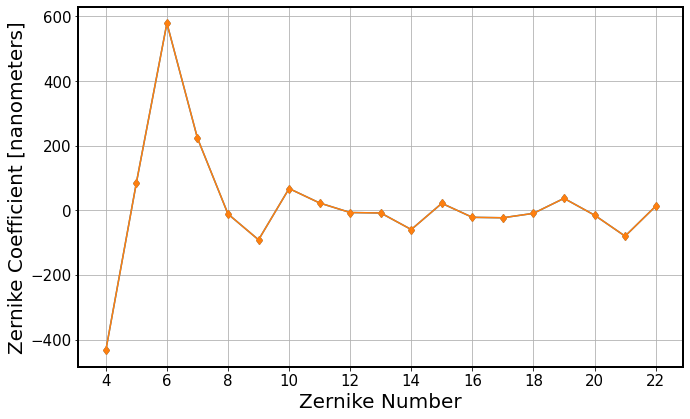

In [23]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# common functions for AOS analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for i in zerCoeff.keys():
    ax1.plot(np.arange(4, 23),1000*zerCoeff[i], 
             '-d', label=i)


ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
#ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()

They are exactly identical. Proceed to implement this update to `CloseLoopTask.py` , and then run the `imgCloseLoop` to make sure all works fine. 

    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst comcam --numOfProc 15 --boresightDeg 0.0 0.0  --output /project/scichris/aos/refcats_DM-34547/imgCloseLoop/

This runs fine; the results can be illustrated: 

In [1]:
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)








/tmp/ipykernel_3566613/2256732466.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'analysisTools' from '/project/scichris/aos/analysisTools.py'>

Saved fig as 1.png


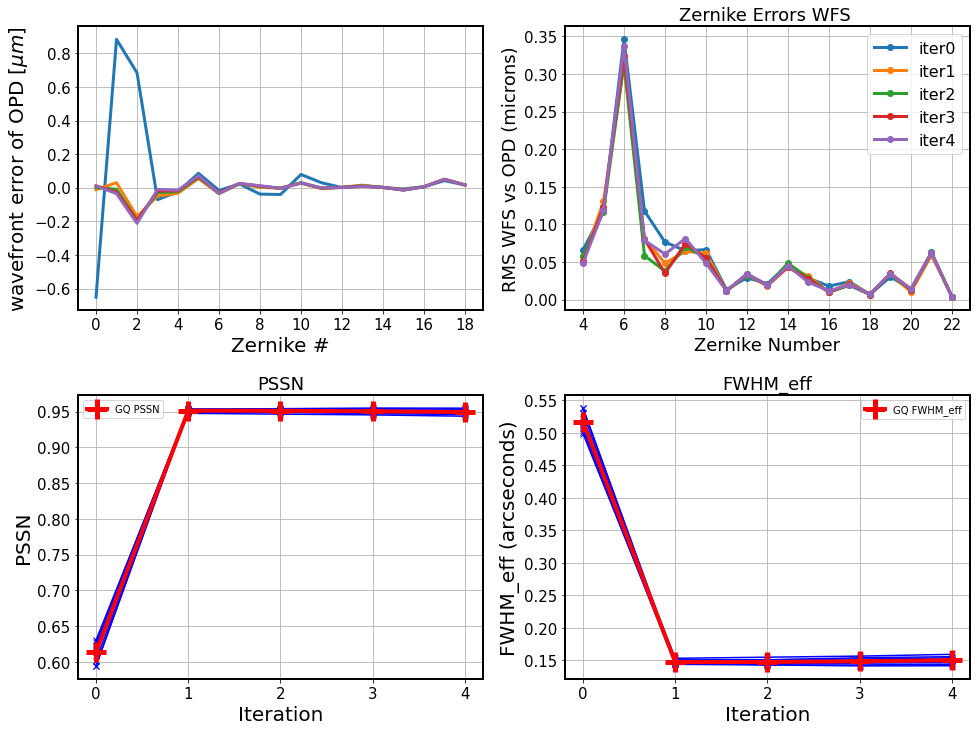

In [2]:
%matplotlib inline
at.plotIterationSummary(data_dir='/project/scichris/aos/refcats_DM-34547/imgCloseLoop2/',
                        iterNum=5
                       )

I ran into `black` issues with pytests . I found out that recently `ts_phosim` was reformatted with black `v22.3` https://github.com/lsst-ts/ts_phosim/pull/62 but the version on `eups list lsst_distrib`  at the time of writing  (w2022_21) was `21.5b1`.
        
Hence I upgraded `pip` and `black` : 

    python -m pip install --upgrade pip
    pip install --upgrade black
    
and now `black` has version `22.3` . Now 

    pytest tests/test_closeLoopTask.py
    
runs successfully. 

Thus I add the change, upgrade the `versionHistory`, and open the PR.

